In [52]:
%reload_ext autoreload
%autoreload 2

In [53]:
import os
import argparse
import sys
import time

from joblib import Parallel, delayed
from utilities2015 import *

%matplotlib inline

In [54]:
dm = DataManager(stack='MD593', section=117, segm_params_id='gridsize200')
# dm._load_image(format='gray')

In [55]:
segmentation = dm.load_pipeline_result('segmentation')
n_superpixels = segmentation.max() + 1

textonmap = dm.load_pipeline_result('texMap')
n_texton = textonmap.max() + 1
texton_hists = dm.load_pipeline_result('texHist')

neighbors = dm.load_pipeline_result('neighbors')

# neighbors_dict = dict(zip(np.arange(n_superpixels), [list(i) for i in neighbors]))
# neighbor_graph = networkx.from_dict_of_lists(neighbors_dict)

# surrounds_sps = dm.load_pipeline_result('clusterSurrounds', 'pkl')
# frontiers_sps = dm.load_pipeline_result('clusterFrontiers', 'pkl')

edge_coords = dict(dm.load_pipeline_result('edgeCoords'))
edge_neighbors = dm.load_pipeline_result('edgeNeighbors')

dedge_vectors = dm.load_pipeline_result('edgeVectors')
dedge_neighbors = dm.load_pipeline_result('dedgeNeighbors')

In [56]:
all_seed_cluster_score_dedge_tuples = dm.load_pipeline_result('allSeedClusterScoreDedgeTuples')

In [57]:
all_seed, all_clusters, all_cluster_scores, all_cluster_dedges = zip(*all_seed_cluster_score_dedge_tuples)

In [58]:
def compute_cluster_coherence_score(cluster, verbose=False):
    
    if len(cluster) > 1:
        cluster_avg = texton_hists[cluster].mean(axis=0)
        ds = np.squeeze(chi2s([cluster_avg], texton_hists[list(cluster)]))
        var = np.sum(ds**2)/len(ds)
    else:
        var = 0
    
    return var

def compute_cluster_significance_score(cluster, verbose=False, method='min'):
    
    cluster_avg = texton_hists[cluster].mean(axis=0)
    
    surround_list = [i for i in set.union(*[neighbors[c] for c in cluster]) if i not in cluster and i != -1]
    
    surrounds = set(surround_list)
  
    if verbose:
        print 'surround_list', surround_list
        
    ds = np.squeeze(chi2s([cluster_avg], texton_hists[surround_list])) 
#     ds = np.squeeze(cdist([cluster_avg], texton_hists[surround_list], kl))
    
#     sur_hists = [texton_hists[list(neighbors[s])].mean(axis=0) for s in surrounds_list]
#     ds = np.squeeze(cdist([cluster_avg], sur_hists, chi2))
    
#     for i in cluster:
#         plt.title('%d'%i)
#         plt.bar(range(n_texton), texton_hists[i]);
#         plt.show();        

#     plt.bar(range(n_texton), cluster_avg);
#     plt.show();
    
#     plt.bar(range(n_texton), texton_hists[surround_list[ds.argmin()]]);
#     plt.show();
    
    if method == 'min':
        surround_dist = ds.min()
    elif method == 'mean':
        surround_dist = ds.mean()
    elif method == 'percentage':
        surround_dist = np.count_nonzero(ds > .2) / float(len(ds)) # hard
    elif method == 'percentage-soft':
        sigma = .05
        surround_dist = np.sum(1./(1+np.exp((.2-ds)/sigma)))/len(ds); #soft
    
    if verbose:
        print 'min', surround_list[ds.argmin()]

#     surds, _ = find_boundary_sps([cluster], neighbors=neighbors, neighbor_graph=neighbor_graph)
    
#     compactness = len(surds[0])**2/float(len(cluster))
#     compactness = .001 * np.maximum(compactness-40,0)**2
    
#     size_prior = .1 * (1-np.exp(-.8*len(cluster)))
    
#     score = surround_dist - compactness + size_prior
    score = surround_dist
    
    return score

In [59]:
all_cluster_coherences = np.array([compute_cluster_coherence_score(cl) for cl in all_clusters])

In [60]:
remaining_cluster_indices = [i for i, (cl, coh, sig) in enumerate(zip(all_clusters, all_cluster_coherences, all_cluster_scores)) 
                if coh < .005 and sig > .03]

In [61]:
all_seed = [all_seed[i] for i in remaining_cluster_indices]
all_clusters = [all_clusters[i] for i in remaining_cluster_indices]
all_cluster_scores = [all_cluster_scores[i] for i in remaining_cluster_indices]
all_cluster_coherences = [all_cluster_coherences[i] for i in remaining_cluster_indices]
all_cluster_dedges = [all_cluster_dedges[i] for i in remaining_cluster_indices]
all_seed_cluster_score_dedge_tuples = [all_seed_cluster_score_dedge_tuples[i] for i in remaining_cluster_indices]

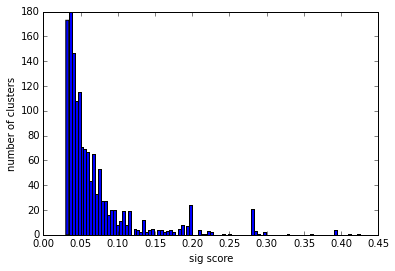

In [62]:
plt.hist(all_cluster_scores, bins=100);
plt.xlabel('sig score');
plt.ylabel('number of clusters');

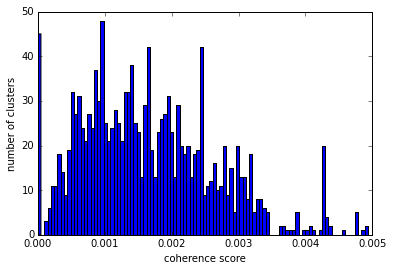

In [63]:
plt.hist(all_cluster_coherences, bins=100);
plt.xlabel('coherence score');
plt.ylabel('number of clusters');

In [64]:
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import average, fcluster, leaders, complete, single, dendrogram, ward

from collections import defaultdict, Counter
from itertools import combinations, chain, product

import networkx

def compute_overlap_minjaccard(c1, c2):
    if isinstance(c1, list):
        c1 = set(c1)
    if isinstance(c2, list):
        c2 = set(c2)
    return float(len(c1 & c2)) / min(len(c1),len(c2))

def compute_overlap_jaccard(c1, c2):
    if isinstance(c1, list):
        c1 = set(c1)
    if isinstance(c2, list):
        c2 = set(c2)
    return float(len(c1 & c2)) / len(c1 | c2)

def compute_overlap_size(c1, c2):
    if isinstance(c1, list):
        c1 = set(c1)
    if isinstance(c2, list):
        c2 = set(c2)
    return len(c1 & c2)

def compute_overlap_partial(indices, sets, metric='jaccard'):
    n_sets = len(sets)
    
    overlap_matrix = np.zeros((len(indices), n_sets))
        
    for ii, i in enumerate(indices):
        for j in range(n_sets):
            c1 = set(sets[i])
            c2 = set(sets[j])
            if len(c1) == 0 or len(c2) == 0:
                overlap_matrix[ii, j] = 0
            else:
                if metric == 'min-jaccard':
                    overlap_matrix[ii, j] = compute_overlap_minjaccard(c1, c2)
                elif metric == 'jaccard':
                    overlap_matrix[ii, j] = compute_overlap_jaccard(c1, c2)
                elif metric == 'size':
                    overlap_matrix[ii, j] = compute_overlap_size(c1, c2)
                else:
                    raise Exception('metric %s is unknown'%metric)
            
    return overlap_matrix

def compute_pairwise_distances(sets, metric):

    partial_overlap_mat = Parallel(n_jobs=16, max_nbytes=1e6)(delayed(compute_overlap_partial)(s, sets, metric=metric) 
                                        for s in np.array_split(range(len(sets)), 16))
    overlap_matrix = np.vstack(partial_overlap_mat)
    distance_matrix = 1 - overlap_matrix
    
    np.fill_diagonal(distance_matrix, 0)
    
    return distance_matrix


def group_tuples(items=None, val_ind=None, dist_thresh = 0.1, distance_matrix=None, metric='jaccard', linkage='complete'):
    '''
    items: a dict or list of tuples
    val_ind: the index of the item of interest within each tuple
    '''
    
    if distance_matrix is not None:
        if items is not None:
            values = map(itemgetter(val_ind), items)
    else:
        if isinstance(items, dict):
            keys = items.keys()
            values = items.values()
        elif isinstance(items, list):
            keys = range(len(items))
            if isinstance(items[0], tuple):
                values = map(itemgetter(val_ind), items)
            else:
                values = items
        else:
            raise Exception('clusters is not the right type')

        assert items is not None, 'items must be provided'
        distance_matrix = compute_pairwise_distances(values, metric)
    
    if items is None:
        assert distance_matrix is not None, 'distance_matrix must be provided.'    
        
    if linkage=='complete':
        lk = complete(squareform(distance_matrix))
    elif linkage=='average':
        lk = average(squareform(distance_matrix))
    elif linkage=='single':
        lk = single(squareform(distance_matrix))

    # T = fcluster(lk, 1.15, criterion='inconsistent')
    T = fcluster(lk, dist_thresh, criterion='distance')
    
    n_groups = len(set(T))
    groups = [None] * n_groups

    for group_id in range(n_groups):
        groups[group_id] = np.where(T == group_id+1)[0]

    index_groups = [[keys[i] for i in g] for g in groups if len(g) > 0]
    item_groups = [[items[i] for i in g] for g in groups if len(g) > 0]
    
    return index_groups, item_groups, distance_matrix

def smart_union(x):
    cc = Counter(chain(*x))
    gs = set([s for s, c in cc.iteritems() if c > (cc.most_common(1)[0][1]*.3)])                           
    return gs


In [65]:
t = time.time()

all_seed_cluster_sig_coh_dedge_tuples = zip(all_seed, all_clusters, all_cluster_scores, all_cluster_coherences,
                                         all_cluster_dedges)

tuple_indices_grouped, tuples_grouped, _ = group_tuples(all_seed_cluster_sig_coh_dedge_tuples, 
                                                         val_ind = 1,
                                                         metric='jaccard',
                                                         dist_thresh=.2)
print time.time() - t

11.103648901


In [66]:
all_seeds_grouped, all_clusters_grouped, \
all_scores_grouped, all_cohs_grouped, all_dedges_grouped = [list(map(list, lst)) for lst in zip(*[zip(*g) for g in tuples_grouped])]

In [67]:
all_scores_grouped = [[compute_cluster_significance_score(g, method='percentage') for g in cg] 
                          for cg in all_clusters_grouped]

In [68]:
group_rep_indices = map(np.argmax, all_scores_grouped)

rep_tuples = [(sc_grp[rep_ind], coh_grp[rep_ind], cl_grp[rep_ind], dedge_grp[rep_ind], gi) 
                for gi, (rep_ind, cl_grp, sc_grp, coh_grp, dedge_grp) in enumerate(zip(group_rep_indices, all_clusters_grouped, 
                                                                              all_scores_grouped, 
                                                                              all_cohs_grouped,
                                                                              all_dedges_grouped))]

rep_tuples_ranked = sorted(rep_tuples, reverse=True)

In [69]:
rep_score_ranked = map(itemgetter(0), rep_tuples_ranked)
rep_coh_ranked = map(itemgetter(1), rep_tuples_ranked)
rep_clusters_ranked = map(itemgetter(2), rep_tuples_ranked)
rep_dedges_ranked = map(itemgetter(3), rep_tuples_ranked)
group_indices_ranked = map(itemgetter(4), rep_tuples_ranked)

rep_entropy_ranked = np.nan_to_num([-np.sum(texton_hists[cl].mean(axis=0)*np.log(texton_hists[cl].mean(axis=0)) )
                      for cl in rep_clusters_ranked])

sp_centroids = dm.load_pipeline_result('spCentroids')[:, ::-1]
rep_centroids_ranked = np.array([sp_centroids[cl].mean(axis=0) for cl in rep_clusters_ranked])

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in multiply


In [70]:
rep_compactness_ranked = np.array([len(eds)**2/float(len(cl)) for cl, eds in zip(rep_clusters_ranked, rep_dedges_ranked)])
rep_compactness_ranked = .001 * np.maximum(rep_compactness_ranked-40,0)**2

In [ ]:
ds = np.linspace(-1.,1.,100)
sigma = .05
plt.plot(ds, 1./(1+np.exp((.2-ds)/sigma)));
plt.xlabel('texture distance');
plt.ylabel('reward');

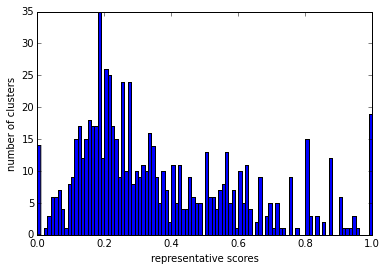

In [71]:
plt.hist(rep_score_ranked, bins=100);
plt.xlabel('representative scores');
plt.ylabel('number of clusters');

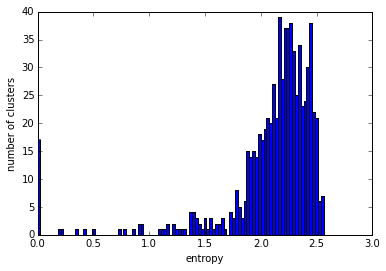

In [72]:
plt.hist(rep_entropy_ranked, bins=100);
plt.xlabel('entropy');
plt.ylabel('number of clusters');

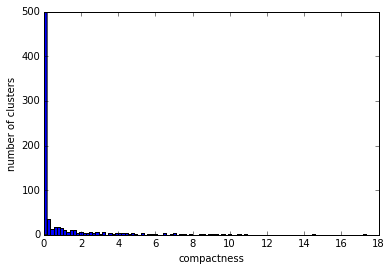

In [73]:
plt.hist(rep_compactness_ranked, bins=100);
plt.xlabel('compactness');
plt.ylabel('number of clusters');

In [74]:
valid_indices = [i for i, (cl, ent, cent, comp) in enumerate(zip(rep_clusters_ranked, 
                                                           rep_entropy_ranked, 
                                                           rep_centroids_ranked,
                                                          rep_compactness_ranked))
                 if len(cl) > 3 and \
#                  comp < 2 and \
                 (ent > 2. or \
                  (cent[0] - dm.xmin > 800 and \
                   dm.xmax - cent[0] > 800 and \
                   cent[1] - dm.ymin > 800 and \
                   dm.ymax - cent[1] > 800)
                 )]

In [75]:
good_cluster_tuples = [(sig, cl, dedges, i) for i, (sig, coh, cl, dedges, grp_ind) in enumerate(rep_tuples_ranked) 
               if i in valid_indices]

In [76]:
good_cluster_indices_grouped, good_cluster_tuples_grouped, _ = group_tuples(good_cluster_tuples, 
                                                        val_ind = 1,
                                                        metric='jaccard',
                                                        dist_thresh=.6)

In [77]:
good_cluster_rep_indices = [np.argmax([sig for sig,cl,dedges,i in tpls]) for tpls in good_cluster_tuples_grouped]

In [78]:
good_cluster_rep_tuples = [tpl_grp[i] for i, tpl_grp in zip(good_cluster_rep_indices, good_cluster_tuples_grouped)]

In [79]:
good_cluster_rep_tuples_ranked = sorted(good_cluster_rep_tuples, reverse=True)

In [80]:
good_clusters = map(itemgetter(1), good_cluster_rep_tuples_ranked)
good_dedges = map(itemgetter(2), good_cluster_rep_tuples_ranked)

In [81]:
sys.stderr.write('%d valid clusters\n'%len(good_clusters))

240 valid clusters


In [ ]:
dm.save_pipeline_result(good_clusters, 'goodClusters')

In [ ]:
dm.save_pipeline_result(good_dedges, 'goodDedges')

In [ ]:
boundary_models = []

for i, es in enumerate(good_dedges[:40]):

    es = list(es)

    interior_texture = texton_hists[list(good_clusters[i])].mean(axis=0)

    surrounds = [e[0] for e in es]
    exterior_textures = np.array([texton_hists[s] if s!=-1 else np.nan * np.ones((texton_hists.shape[1],)) 
                                  for s in surrounds])
    # how to deal with -1 in surrounds? Assign to an all np.nan vector

    points = np.array([edge_coords[frozenset(e)].mean(axis=0) for e in es])
    center = points.mean(axis=0)

    boundary_models.append((es, interior_texture, exterior_textures, points, center))    

In [ ]:
dm.save_pipeline_result(boundary_models, 'boundaryModels')

In [ ]:
print compute_overlap_jaccard(good_clusters[35], good_clusters[34])
print compute_overlap_minjaccard(good_clusters[35], good_clusters[34])
print compute_overlap_size(good_clusters[35], good_clusters[34])

In [27]:
def which_clusters_contain(sps):
    return [i for i, c in enumerate(good_clusters) if all(j in c for j in sps)]

In [28]:
which_clusters_contain([1005])

[28]

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/PIL/Image.py:2261: DecompressionBombWarning: Image size (203470848 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


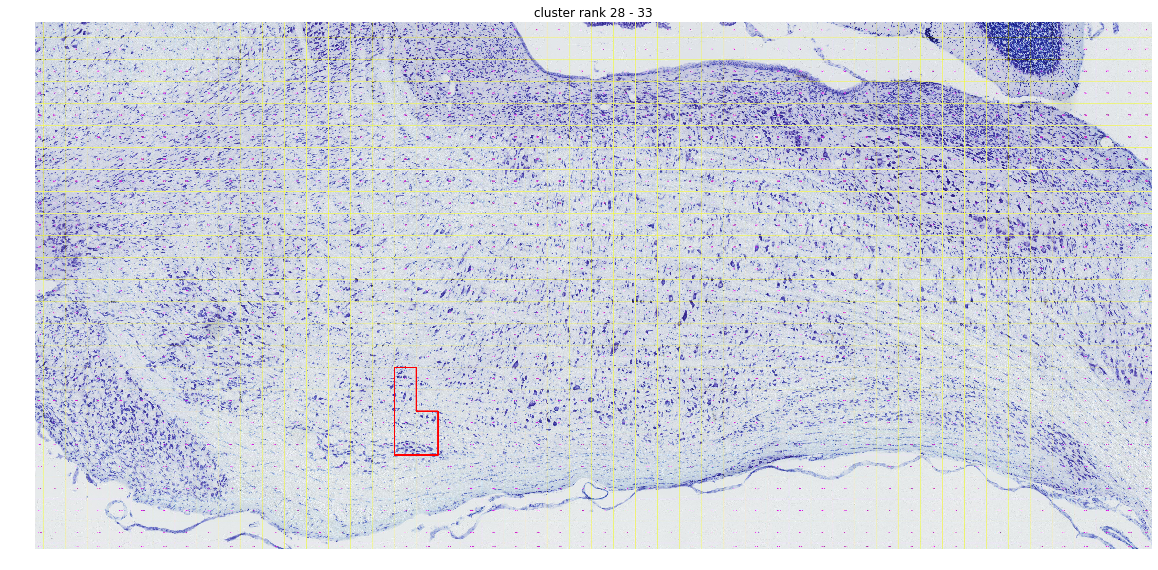

In [29]:
for i in which_clusters_contain([1005]):
    viz = dm.visualize_edge_set(good_dedges[i], bg='segmentationWithText')
    # display(viz)
    plt.figure(figsize=(20,20));
    plt.title('cluster rank %d - %d'%(i, i+5))
    plt.imshow(viz);
    plt.axis('off');
    plt.show();

In [ ]:
cluster = good_clusters[58]
deges = good_dedges[58]

compactness = len(deges)**2/float(len(cluster))
# compactness = .001 * np.maximum(compactness-40,0)**2
print compactness

# print cdist(texton_hists[cluster], texton_hists[cluster], chi2).max()

# cluster_avg = texton_hists[cluster].mean(axis=0)
# ds = np.squeeze(chi2s([cluster_avg], texton_hists[list(cluster)]))
# print np.sum(ds**2)/len(ds)

In [ ]:
cluster = good_clusters[48]
deges = good_dedges[48]

# cluster_avg = texton_hists[cluster].mean(axis=0)
# ds = np.squeeze(chi2s([cluster_avg], texton_hists[list(cluster)]))
# print np.sum(ds**2)/len(ds)

# compactness = len(deges)**2/float(len(cluster))
# print compactness

ds = cdist(texton_hists[cluster], texton_hists[cluster], chi2)
r,c = np.unravel_index(ds.argmax(), ds.shape)
print cluster[r], cluster[c]

In [ ]:
cluster = good_clusters[36]
deges = good_dedges[36]

# cluster_avg = texton_hists[cluster].mean(axis=0)
# ds = np.squeeze(chi2s([cluster_avg], texton_hists[list(cluster)]))
# print np.sum(ds**2)/len(ds)

compactness = len(deges)**2/float(len(cluster))
print compactness

In [ ]:
for i in range(30,60,5):
    viz = dm.visualize_edge_sets(good_dedges[i:i+5], show_set_index=True, bg='segmentationWithText')
    # display(viz)
    plt.figure(figsize=(20,20));
    plt.title('cluster rank %d - %d'%(i, i+5))
    plt.imshow(viz);
    plt.axis('off');
    plt.show();

In [ ]:
all_cluster_probs = np.exp(-np.asarray(all_cluster_scores)*10.)

In [ ]:
plt.hist(all_cluster_scores, bins=100);
plt.title('distribution of cluster scores');
plt.xlabel('score');
plt.ylabel('number of clusters');
plt.show();

plt.hist(all_cluster_probs, bins=100);
plt.title('distribution of significant cluster probabilities');
plt.xlabel('probability');
plt.ylabel('number of clusters');
plt.show();

In [ ]:
import itertools
from collections import defaultdict

In [ ]:
voters = defaultdict(set)
for (i1, (s1,c1)), (i2, (s2,c2)) in itertools.product(enumerate(zip(all_seed[:1000], all_cluster_dedges[:1000])), 
                                enumerate(zip(all_seed[:1000], all_cluster_dedges[:1000]))):
    common_dedges = set(c1) & set(c2)
    voters[frozenset(common_dedges)].add(frozenset([i1, i2]))

In [ ]:
voters.keys()

In [ ]:
voters_flat = dict([(dedges, set.union(*map(set, pairs))) for dedges, pairs in voters.iteritems()])

In [ ]:
common_dedges_score = [np.asarray(all_cluster_scores)[list(sptr_indices)].mean() for dedges, sptr_indices in voters_flat.iteritems()]

In [ ]:
common_dedges_scores_ranked, common_dedges_ranked = zip(*sorted(zip(common_dedges_score, voters_flat.keys()), reverse=True))

In [ ]:
relevant_dedges = [d for d in common_dedges_ranked if len(d) == 5]

In [ ]:
viz = dm.visualize_edge_sets(common_dedges_ranked[10:20], bg='segmentationWithText', show_set_index=True)
display(viz)

In [ ]:
common_dedges = voters_flat.keys()

In [ ]:
common_dedges_indices_grouped, common_dedges_grouped, _ = group_clusters(common_dedges[:1000], 
                                                                         metric='min-jaccard',
                                                                        dist_thresh=.2)

In [ ]:
common_dedge_group_scores = [np.max([common_dedges_score[i] for i in indices]) for indices in common_dedges_indices_grouped]

In [ ]:
common_dedge_group_representatives = [common_dedges[indices[np.argmax([common_dedges_score[i] for i in indices])]] for indices in common_dedges_indices_grouped]

In [ ]:
common_dedge_group_score_ranked ,\
common_dedge_indices_grouped_ranked,\
common_dedge_group_representatives_ranked, \
common_dedge_groups_ranked = zip(*sorted(zip(common_dedge_group_scores, 
                                             common_dedges_indices_grouped,
                                             common_dedge_group_representatives,
                                             common_dedges_grouped), reverse=True))

In [ ]:
viz = dm.visualize_edge_sets([common_dedges[i] for i in common_dedges_indices_grouped[0]], 
                             bg='segmentationWithText', show_set_index=True)
display(viz)

In [ ]:
viz = dm.visualize_edge_sets(common_dedge_group_representatives_ranked[:100], bg='segmentationWithText', show_set_index=True)
display(viz)

In [ ]:
segment_score_dict = defaultdict(int)
segment_supporter_dict = defaultdict(list)

for seed, cl, prob, dedge_list in zip(all_seed, all_clusters, all_cluster_probs, all_cluster_dedges):
    n_edges = len(dedge_list)
    dummy_list = dedge_list + dedge_list
    for start_edge_ind in range(n_edges):
        segm = dummy_list[start_edge_ind:start_edge_ind+5]
        segment_score_dict[frozenset(segm)] += -np.log(1-.2*prob)
#         segment_score_dict[frozenset(segm)] += sig_score/len(cl)
#         segment_score_dict[frozenset(segm)] += - np.log(1-sig_score)
        
        segment_supporter_dict[frozenset(segm)].append(seed)
        
segment_score_dict.default_factory = None
segment_supporter_dict.default_factory = None

In [ ]:
segment_prob_dict = dict([(segm, 1-np.exp(-score)) for segm, score in segment_score_dict.iteritems()])

# segment_prob_dict = dict([(segm, 1-np.exp(-score/len(sptrs))) for (segm, score), sptrs in zip(segment_score_dict.iteritems(),
#                                                                          segment_supporter_dict.itervalues())])

In [ ]:
plt.hist(segment_score_dict.values(), bins=100);
plt.title('distribution of segment scores');
plt.xlabel('score');
plt.ylabel('number of segments');
plt.show();

plt.hist(segment_prob_dict.values(), bins=100);
# plt.hist(segment_prob_dict.values(), bins=np.linspace(0.9999, 1.0, 100));
plt.title('distribution of segment probs');
plt.xlabel('probability');
plt.ylabel('number of segments');
plt.show();

In [ ]:
plt.hist(map(len, segment_supporter_dict.values()), bins=100);
plt.title('distribution of supporter size of segments');
plt.xlabel('supporter size');
plt.ylabel('number of segments');

In [ ]:
from operator import itemgetter
segment_score_sorted = sorted(segment_score_dict.items(), key=itemgetter(1), reverse=True)
segment_prob_sorted = sorted(segment_prob_dict.items(), key=itemgetter(1), reverse=True)

In [ ]:
good_segments = [set(i[0]) for i in segment_prob_sorted if i[1] > .99]
# good_segments = [set(i[0]) for i in segment_prob_sorted if i[1] > .999]
# good_segments = [set(i[0]) for i in segment_score_sorted if i[1] > 30]
print len(good_segments)

In [ ]:
good_edges = set.union(*good_segments)

In [ ]:
viz = dm.visualize_edge_set(good_edges, bg='segmentationWithText')
display(viz)

In [ ]:
relevant_edges = set.union(*[set(segm) for segm, sptrs in segment_supporter_dict.iteritems() if 2167 in sptrs])

In [ ]:
for segm, sptrs in segment_supporter_dict.iteritems():
    if 2167 in sptrs:
        print segment_score_dict[segm]

In [ ]:
segment_supporters = segment_supporter_dict.values()

In [ ]:
good_segment_supporters = dict((frozenset(seg), segment_supporter_dict[frozenset(seg)]) for seg in good_segments)

In [ ]:
good_segment_groups, _, _ = group_clusters(clusters=good_segment_supporters, metric='jaccard')

In [ ]:
good_edge_groups = [set.union(*map(set, segm_list)) for segm_list in good_segment_groups]

In [ ]:
good_edge_group_scores = [np.mean([segment_score_dict[segm] for segm in segm_list]) for segm_list in good_segment_groups]
good_edge_group_probs = [np.mean([segment_prob_dict[segm] for segm in segm_list]) for segm_list in good_segment_groups]

In [ ]:
plt.hist(good_edge_group_scores, bins=100);
plt.title('distribution of edge group scores');
plt.xlabel('edge group scores');
plt.ylabel('number of groups');
plt.show();

plt.hist(good_edge_group_probs, bins=100);
plt.title('distribution of edge group probs');
plt.xlabel('probability');
plt.ylabel('number of groups');

In [ ]:
good_edge_group_probs_ranked, \
good_edge_group_scores_ranked, \
good_edge_groups_ranked, \
good_edge_group_inices_ranked = zip(*sorted(zip(good_edge_group_probs,
                                                good_edge_group_scores, 
                                                good_edge_groups,
                                                range(len(good_edge_group_scores))), reverse=True))

In [ ]:
viz = dm.visualize_edge_sets(good_edge_groups_ranked[:200], bg='segmentationWithText', show_set_index=True)
display(viz)

In [ ]:
viz = dm.visualize_edge_set({(1649, 1752),
   (1650, 1753),
   (1751, 1752),
   (1754, 1753),
   (1754, 1857),
   (1855, 1752),
   (1855, 1856),
   (1858, 1857),
   (1858, 1961),
   (1958, 1959),
   (1962, 1961),
   (1962, 2065),
   (2061, 2062),
   (2066, 2065),
   (2164, 2165),
   (2169, 2168),
   (2267, 2268),
   (2271, 2168),
   (2271, 2270),
   (2370, 2371),
   (2473, 2474),
   (2475, 2372),
   (2475, 2474),
   (2577, 2474)}, bg='segmentationWithText')
display(viz)

In [ ]:
(1958,1959) in good_edges

In [ ]:
segment_score_dict[frozenset({(1855, 1856),
            (1958, 1959),
            (2061, 2062),
            (2164, 2165),
            (2267, 2268)})]

In [ ]:
[segm for segm in good_segments if (1958, 1959) in segm]

In [ ]:
[segment_score_dict[frozenset(segm)] for segm in good_segments if (1958, 1959) in segm]

In [ ]:
(1958, 1959) in good_edges

In [ ]:
good_edge_group_scores_ranked[462]

In [ ]:
[(rank, segm) for rank, segm in enumerate(good_edge_groups_ranked) if (1958,1959) in segm]

In [ ]:
# votes for directed edgelets
dedge_vote_dict = defaultdict(float)

sys.stderr.write('compute supporter set of each edgelet ...\n')
t = time.time()

# Compute the supporter sets of every edgelet, based on region proposals
# supporter_all[(100,101)] is the set of superpixels that supports directed edgelet (100,101)
dedge_supporters = defaultdict(list)
    
# for s in range(n_superpixels):

for s, c in all_see_cluster_tuples:
#     c = list(expansion_clusters[s])

    interior_texture = texton_hists[c].mean(axis=0)
    b_sps = surrounds_sps[s]
    b_contrasts = cdist(texton_hists[b_sps], interior_texture[np.newaxis, :], chi2)

    for b_sp, b_contrast in zip(b_sps, b_contrasts):
        int_sps = neighbors[b_sp] & set(c)
        for int_sp in int_sps:
            # weight of each edgelet is the contrast normalized by region size
#             weight = float(b_contrast) / max(len(c), 5)
#             weight = 1. / max(len(c), 5)
            weight = 1.
            dedge_vote_dict[(b_sp, int_sp)] += weight
#             dedge_vote_dict[(int_sp, b_sp)] += weight
            dedge_supporters[(b_sp, int_sp)].append(s) # (border_sp, interior_sp) or (out, in)

dedge_vote_dict.default_factory = None
dedge_supporters.default_factory = None
    
sys.stderr.write('done in %f seconds\n' % (time.time() - t))

In [ ]:
all_edges = edge_coords.keys()
all_dedges = set(chain(*[[(i,j),(j,i)] for i,j in all_edges]))

try:
    edge_contained_by = dm.load_pipeline_result('edgeContainedBy', 'pkl')
    print "edgeContainedBy.pkl already exists, skip"

except:

	sys.stderr.write('compute edge-contained-by lookup table...\n')
	t = time.time()

	cluster_edges = dm.load_pipeline_result('clusterEdges', 'pkl')

	def f(c, e):
	    q = set(chain(*[[(i,j),(j,i)] for i,j in combinations(c, 2) if frozenset([i,j]) in all_edges]))
	    return q | set(e)

	contain_edges = Parallel(n_jobs=16)(delayed(f)(c,e) for c, e in zip(expansion_clusters, cluster_edges))

	edge_contained_by = defaultdict(set)
	for sp, es in enumerate(contain_edges):
	    for e in es:
	        edge_contained_by[e].add(sp)

	edge_contained_by.default_factory = None

# 	dm.save_pipeline_result(edge_contained_by, 'edgeContainedBy', 'pkl')

	sys.stderr.write('done in %f seconds\n' % (time.time() - t))

In [ ]:
# only consider dedges that receive non-zero vote
nz_dedges = dedge_vote_dict.keys()

sys.stderr.write('filter dedges ...\n')
t = time.time()

# compute contrast of each dedge
# dedge_contrast = dict([((i,j), chi2(texton_hists[i], texton_hists[j])) for i,j in all_dedges])
dedge_contrast = dict([((i,j), chi2(texton_hists[i], texton_hists[dedge_supporters[(i,j)]].mean(axis=0))) 
                       for i,j in nz_dedges])

# filter dedges, require contrast > .5 and contained by at least 4 growed regions
nz_dedges2 = [e for e, sps in edge_contained_by.iteritems() if len(sps) > 3 and e in nz_dedges]
nz_dedges2 = [e for e in nz_dedges2 if dedge_contrast[e] > .5]

# compute stop ratio of each dedge
dedge_stopperness = dict([(e, dedge_vote_dict[e]/len(edge_contained_by[e])) for e in nz_dedges2])

# filter dedges, require stop ratio to be 1.
nz_dedges2 = [e for e in nz_dedges2 if dedge_stopperness[e] > .8]
#     print len(nz_dedges2), 'valid edges'

sys.stderr.write('done in %f seconds\n' % (time.time() - t))

In [ ]:
len(nz_dedges2)

In [ ]:
t = time.time()
viz = dm.visualize_edge_sets([nz_dedges2], directed=False, colors=np.array([[255,0,0]]),
                            bg='segmentationWithText')
print time.time() - t

In [ ]:
display(viz)

In [ ]:

sys.stderr.write('compute expanded supporter set for each edgelet ...\n')

# find union supporter set for each dedge
dedge_expandedSupporters = dict([(e, smart_union([expansion_clusters[s] for s in dedge_supporters[e]])) 
                             for e in nz_dedges2])

# cluster union supporter sets
dedges_grouped, dedge_supporters_grouped, _ = group_clusters(clusters=dict((e, dedge_expandedSupporters[e]) for e in nz_dedges2),
                                                             dist_thresh=.01, linkage='complete', metric='jaccard')
dedges_grouped = map(set, dedges_grouped)
ngroup = len(dedges_grouped)

sys.stderr.write('done in %f seconds\n' % (time.time() - t))

#     print len(dedges_grouped), 'edge groups'

sys.stderr.write('compute supporter set consistency factor...\n')
t = time.time()
# compute cluster "centroids"
dedge_group_supporters = map(smart_union, dedge_supporters_grouped)

# compute centroid distances
# analyze supporter set consistency factor (1)
dedge_group_supporter_distmat = compute_pairwise_distances(dedge_group_supporters, metric='jaccard')
np.fill_diagonal(dedge_group_supporter_distmat, 0)

sys.stderr.write('done in %f seconds\n' % (time.time() - t))


sys.stderr.write('compute connectivity factor...\n')
t = time.time()

# analyze connectivity factor (2)
G = networkx.from_dict_of_lists(dedge_neighbors)
conns = [[set() if any([sorted(e1)==sorted(e2) for e1, e2 in product(eg1, eg2)]) 
          else set([(i,j) for i,j in G.edges(eg1|eg2) if (i in eg1 and j in eg2) or (j in eg1 and i in eg2)]) 
         for eg1 in dedges_grouped] for eg2 in dedges_grouped]
conns_flat = [a for b in conns for a in b ]
dedge_group_edgeConn_distmat = np.reshape(map(lambda x: len(x) < 1, conns_flat), (ngroup, ngroup))
np.fill_diagonal(dedge_group_edgeConn_distmat, 0)

sys.stderr.write('done in %f seconds\n' % (time.time() - t))


sys.stderr.write('compute connectivity factor...\n')
t = time.time()

# analyze texture similarity factor (3)
dedge_group_supporterTex_distmat = np.reshape([chi2(texton_hists[list(sps1)].mean(axis=0), texton_hists[list(sps2)].mean(axis=0))  
		for sps1, sps2 in product(dedge_group_supporters, dedge_group_supporters)], (ngroup, ngroup))

sys.stderr.write('done in %f seconds\n' % (time.time() - t))


sys.stderr.write('combine three factors ...\n')
t = time.time()

# combine above three factors
dedge_group_distmat = 1 - (1-dedge_group_edgeConn_distmat) * (1-dedge_group_supporter_distmat>0.1) * (dedge_group_supporterTex_distmat < .25)

sys.stderr.write('done in %f seconds\n' % (time.time() - t))


sys.stderr.write('further cluster dedge groups ...\n')
t = time.time()

# further cluster dedge groups
_, edge_groups, _ = group_clusters(clusters=dedges_grouped, 
                               distance_matrix=dedge_group_distmat, 
                               dist_thresh=.5, linkage='single')

sys.stderr.write('done in %f seconds\n' % (time.time() - t))

#     print len(edge_groups), 'edge groups after considering connectivity'

edge_groups = map(lambda x: set(chain(*x)), edge_groups)

# sort clusters by total contrast
edge_groups_sorted = sorted(edge_groups, key=lambda x: sum(dedge_contrast[e] for e in x), reverse=True)
edge_group_supporters_sorted = [smart_union(map(lambda e: dedge_expandedSupporters[e], es)) 
                                for es in edge_groups_sorted]


viz = dm.visualize_edge_sets(edge_groups_sorted[:40], text_size=3, img=segmentation_vis)
dm.save_pipeline_result(viz, 'topLandmarks', 'jpg')

dm.save_pipeline_result(edge_groups_sorted, 'goodEdgeSets', 'pkl')
dm.save_pipeline_result(edge_group_supporters_sorted, 'goodEdgeSetsSupporters', 'pkl')


boundary_models = []

for i, es in enumerate(edge_groups_sorted[:40]):
    
    es = list(es)
    
    interior_texture = texton_hists[list(edge_group_supporters_sorted[i])].mean(axis=0)

    surrounds = [e[0] for e in es]
    exterior_textures = np.array([texton_hists[s] if s!=-1 else np.nan * np.ones((texton_hists.shape[1],)) 
                                  for s in surrounds])
    # how to deal with -1 in surrounds? Assign to an all np.nan vector

    points = np.array([edge_coords[frozenset(e)].mean(axis=0) for e in es])
    center = points.mean(axis=0)

    boundary_models.append((es, interior_texture, exterior_textures, points, center))

dm.save_pipeline_result(boundary_models, 'boundaryModels', 'pkl')
